# This notebook makes the Pseudobulks from processed single-cell data and formats relevant metadata

Data format requirements for single-cell data:
- processed data is not scaled
- cells are filtered such that low-quality cells are removed (for example: filter out cells with less than 200 genes and genes expressed in less than 3 cells, and > 5% MT reads)
- data is saved as an AnnData object and you have sample IDs, gene IDs, and cell-type labels

The end product of this notebook will include the following `.pkl` files per each sample, stimulation and datasplit combination:
- Pseudobulk gene expression (`*_pseudo_splits.pkl`) and proportions (`*_prop_splits.pkl`) from random cell type mixture and single cell type dominant mixture
- Metadata (`*_meta_splits.pkl`) with the following fields
  - the observations have columns named: "sample_id", "stim", "isTraining"
  - sample_id: unique IDs for the samples
  - stim: is "STIM" or "CTRL", denotes if the sample is "female" or "male"
  - isTraining: 'Train' or 'Test',  denotes whether the sample is used during training or not.

In [1]:
import random
import sys
import pathlib
import yaml
import subprocess
import pickle

import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.stats import median_abs_deviation

## Preprocessing Parameters

In [2]:
CELL_TYPE_COL = 'encode_celltype'
SAMPLE_ID_COL = 'sample_id'
STIM_COL = 'stim'

GENE_ID_COL = 'gene_ids'

DATASPLIT_COL = 'isTraining'

DATASPLIT_SEED = 42
TEST_SIZE = 0.2

## Load config
The config file specifies the path to data and software repo (due to currently in active development)

In [3]:
# Get the root directory of the analysis repository
REPO_ROOT = subprocess.run(
    ["git", "rev-parse", "--show-toplevel"], capture_output=True, text=True
).stdout.strip()
REPO_ROOT = pathlib.Path(REPO_ROOT)

CONFIG_FILE = REPO_ROOT / 'config.yml'
assert CONFIG_FILE.exists(), f"Config file not found at {CONFIG_FILE}"

with open(CONFIG_FILE, 'r') as file:
    config_dict = yaml.safe_load(file)

## Add dev buddi fork to path and import

In [4]:
buddi_fork_path = config_dict['software_path']['buddi_v2']
buddi_fork_path = pathlib.Path(buddi_fork_path)
assert buddi_fork_path.exists(), f"buddi fork not found at {buddi_fork_path}"

sys.path.insert(0, str(buddi_fork_path))
# this is quite ugly, once activate modifications are done this will be changed
# to a proper installation + import
from buddi_v2.preprocessing.sc_augmentor import SCAugmentor, load_sc_augmentation_dir
from buddi_v2.plotting.plot_data import plot_data

2025-05-01 11:24:24.226479: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-01 11:24:24.235432: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746120264.244700 1479390 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746120264.247640 1479390 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746120264.256003 1479390 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Retrieve Path to Processed Single-Cell RNA-seq Data and relevant Metadata

In [5]:
STUDY_GEO_ID = 'GSE154600' # TODO consider whether to move this into config.yml as well
SC_DATA_PATH = pathlib.Path(config_dict['data_path']['sc_data_path'])

SC_ADATA_PATH = SC_DATA_PATH / f'{STUDY_GEO_ID}_processed'
assert SC_ADATA_PATH.exists(), f"Processed Single-cell Data path {SC_ADATA_PATH} does not exist"
SC_ADATA_FILE = SC_ADATA_PATH / f'{STUDY_GEO_ID}_processed.h5ad'
assert SC_ADATA_FILE.exists(), f"Processed Single-cell Data file {SC_ADATA_FILE} does not exist"

SC_METADATA_PATH = SC_DATA_PATH / f'{STUDY_GEO_ID}_metadata'
assert SC_METADATA_PATH.exists(), f"Single-cell Metadata path {SC_METADATA_PATH} does not exist"

## Define Path to write Pre-Processing Outputs

In [6]:
PREPROCESSING_OUTPUT_PATH = REPO_ROOT / 'processed_data'
assert PREPROCESSING_OUTPUT_PATH.exists(), f"Preprocessing output path {PREPROCESSING_OUTPUT_PATH} does not exist"
SC_AUGMENTED_DATA_PATH = PREPROCESSING_OUTPUT_PATH / 'sc_augmented'
SC_AUGMENTED_DATA_PATH.mkdir(exist_ok=True, parents=True)

## Preprocessing of scRNA-seq Anndata before Moving to Pseudobulk
### Load and Preprocess Anndata

In [7]:
adata = sc.read_h5ad(SC_ADATA_FILE)

# checking if the defined columns are present in the adata.obs
assert CELL_TYPE_COL in adata.obs.columns, f"Column {CELL_TYPE_COL} not found in adata.obs"
assert SAMPLE_ID_COL in adata.obs.columns, f"Column {SAMPLE_ID_COL} not found in adata.obs"
assert STIM_COL in adata.obs.columns, f"Column {STIM_COL} not found in adata.obs"

In [8]:
adata.var_names_make_unique()
adata.var[GENE_ID_COL] = adata.var.index.tolist()

# replace underscores with hyphens in the sample_id column
adata.obs[SAMPLE_ID_COL] = adata.obs[SAMPLE_ID_COL].str.replace('_', '-')
adata.obs[STIM_COL] = 'white' # Assume this deidentified sc dataset is all white individual

### Cell Type Stats

sample_id          Samp-T59  Samp-T76  Samp-T77  Samp-T89  Samp-T90
encode_celltype                                                    
Adipocytes              925      2627       241       120        42
B-cells                 154        67       286       476       186
CD4+ T-cells            555       117       190       269       345
CD8+ T-cells           1542      2406      1452      1430      1353
Endothelial cells        73       318        31        87        30
Epithelial cells       2587        49       434       222       729
Fibroblasts             373      3522        37       284       169
Macrophages            2321       617       444       456       141
Mesangial cells        1175       606      1651        13        43
Monocytes              1606       929        88       729       155
NK cells                378       618       120       205        88


/tmp/ipykernel_1479390/1808085958.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_df = adata.obs.groupby([SAMPLE_ID_COL, CELL_TYPE_COL]).size().reset_index(name='count')


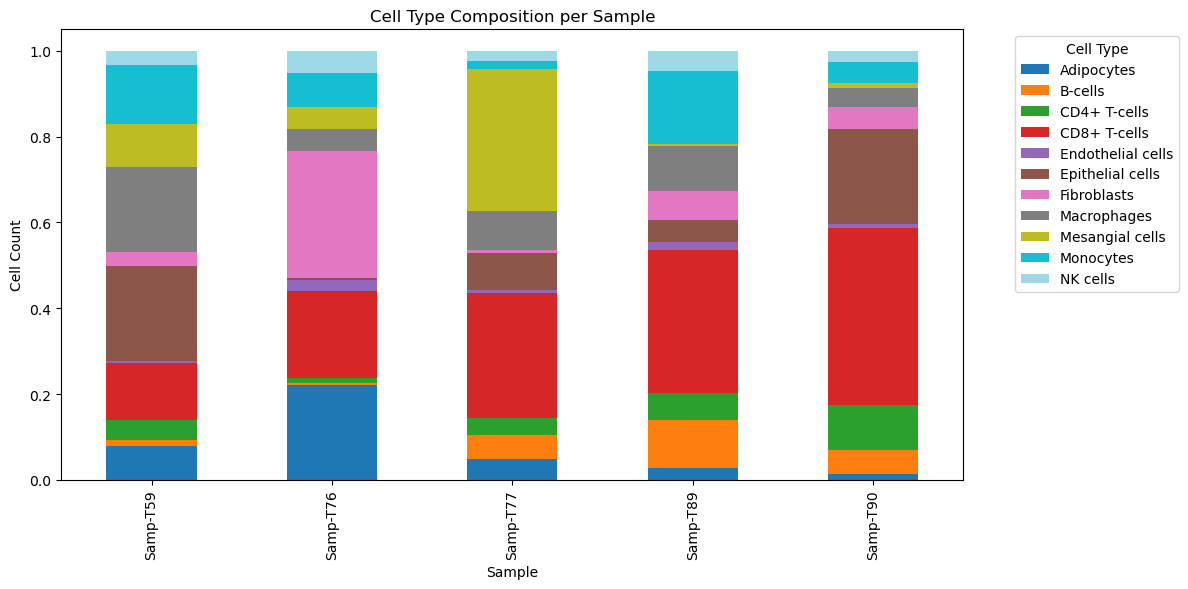

In [9]:
ct = pd.crosstab(adata.obs[CELL_TYPE_COL], adata.obs[SAMPLE_ID_COL])
with pd.option_context(
    'display.max_rows', None,
    'display.max_columns', None,
    'display.width', None,
    'display.max_colwidth', None
):
    print(ct)

count_df = adata.obs.groupby([SAMPLE_ID_COL, CELL_TYPE_COL]).size().reset_index(name='count')
pivot_df = count_df.pivot(index=SAMPLE_ID_COL, columns=CELL_TYPE_COL, values='count').fillna(0)
pivot_df = pivot_df.div(pivot_df.sum(axis=1), axis=0)

fig, ax = plt.subplots(figsize=(12, 6))
pivot_df.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20', ax=ax)

plt.xlabel('Sample')
plt.ylabel('Cell Count')
plt.title('Cell Type Composition per Sample')
plt.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Stim Stats

In [10]:
ct = pd.crosstab(adata.obs[SAMPLE_ID_COL], adata.obs[STIM_COL])
with pd.option_context(
    'display.max_rows', None,
    'display.max_columns', None,
    'display.width', None,
    'display.max_colwidth', None
):
    print(ct)

stim       white
sample_id       
Samp-T59   11689
Samp-T76   11876
Samp-T77    4974
Samp-T89    4291
Samp-T90    3281


### Perform train test split holding out samples completely

In [11]:
unique_sample_ids = adata.obs[SAMPLE_ID_COL].unique()
print(f"All unique sample IDs: {unique_sample_ids}")

random.seed(DATASPLIT_SEED)

n_test_samples = int(np.ceil(len(unique_sample_ids) * TEST_SIZE))
test_sample_ids = random.sample(list(unique_sample_ids), n_test_samples)
print(f"Test sample ID(s) selected for hold-out as test dataset: {test_sample_ids}")

test_idx = np.where(adata.obs[SAMPLE_ID_COL].isin(test_sample_ids))[0]
test_idx = adata.obs.index[test_idx]
adata.obs.loc[:, DATASPLIT_COL] = 'Train'
adata.obs.loc[test_idx, DATASPLIT_COL] = 'Test'

print("\n\nData Split Sanity Check Tabulation")
contingency_table = pd.crosstab(adata.obs[SAMPLE_ID_COL], adata.obs[DATASPLIT_COL])
with pd.option_context(
    'display.max_rows', None,
    'display.max_columns', None,
    'display.width', None,
    'display.max_colwidth', None
):
    print(contingency_table)

All unique sample IDs: ['Samp-T59' 'Samp-T76' 'Samp-T77' 'Samp-T89' 'Samp-T90']
Test sample ID(s) selected for hold-out as test dataset: ['Samp-T59']


Data Split Sanity Check Tabulation
isTraining   Test  Train
sample_id               
Samp-T59    11689      0
Samp-T76        0  11876
Samp-T77        0   4974
Samp-T89        0   4291
Samp-T90        0   3281


## Make Pseudobulks

In [12]:
augmentor = SCAugmentor(
    adata=adata,
    sample_col=SAMPLE_ID_COL,
    split_col=DATASPLIT_COL,
    celltype_col=CELL_TYPE_COL,
    gene_id_col=GENE_ID_COL,
)

-----------------------------------------------
PseudoBulkAugmentor initialised with:
  #Samples : 5
  #Stims   : 1
  #Splits  : 2
  #Cell types : 11

Contingency table (sample × split):
isTraining   Test  Train
sample_id               
Samp-T59    11689      0
Samp-T76        0  11876
Samp-T77        0   4974
Samp-T89        0   4291
Samp-T90        0   3281
-----------------------------------------------



In [13]:
augmentor.configure_random_pseudobulks(
    n_bulks=1_000, # 1, 000 generated per sample
    n_cells=5_000, # 5, 000 cells per pseudobulk
    mean=5.0, # Mean for log-normal distribution sampling
    variance_range=(1.0, 3.0), # Variance range for log-normal distribution sampling
)
augmentor.configure_realistic_pseudobulks(
    n_bulks=0, # No realistic pseudobulks generated
)
augmentor.configure_singlecell_pseudobulks(
    n_bulks=100, # 100 pseudobulks generated per sample per cell type 
    n_cells=5_000,
    background_prop=0.01,
)

augmentor.configure_pseudobulk_noise(
    cell_noise=(0, 0.1), # randomly generated noise with log-normal mean 0 and std 0.1
    use_sample_noise=False, # Do not use sample noise
)

print("Random  :", augmentor._random_cfg)
print("Realistic:", augmentor._realistic_cfg)
print("Single  :", augmentor._single_cfg)
print("Noise   :", augmentor._noise_cfg)

Random  : {'n_bulks': 1000, 'n_cells': 5000, 'mean': 5.0, 'variance_range': (1.0, 3.0)}
Realistic: {'n_bulks': 0, 'n_cells': 5000, 'min_corr': 0.8}
Single  : {'n_bulks': 100, 'n_cells': 5000, 'background_prop': 0.01}
Noise   : {'cell_noise': [array([1.26821465, 1.11060258, 0.92362622, ..., 0.98140407, 1.08598371,
       1.00658762]), array([1.01940133, 0.78219192, 0.99277162, ..., 1.04330572, 1.03747984,
       0.98277976]), array([0.90925037, 0.78813345, 0.95267075, ..., 0.9232417 , 1.01575461,
       1.08221247]), array([0.99970733, 1.02053415, 0.91141932, ..., 1.03045998, 0.94892122,
       1.06957523]), array([1.07578598, 1.02867725, 0.962869  , ..., 1.01771713, 1.1609142 ,
       1.08529587]), array([0.8770767 , 1.01895249, 0.92457863, ..., 1.32275298, 1.10006087,
       1.09974243]), array([0.90727994, 1.02275868, 0.89172532, ..., 1.22794532, 0.97984711,
       1.02827617]), array([0.73706265, 1.18317413, 0.97234048, ..., 1.09071121, 1.05707669,
       0.941301  ]), array([0.9374

In [14]:
augmentor.run(
    save_path=SC_AUGMENTED_DATA_PATH,
    augmentation_name=f'{STUDY_GEO_ID}_augmented',
    seed=42,
    overwrite=True,
)

Generating pseudo‑bulk profiles for sample Samp-T59, stim white, split Test …
  >Generating random‑prop pseudo‑bulks…


100%|██████████| 1000/1000 [00:24<00:00, 40.63it/s]


  >Generating single‑cell‑dominant pseudo‑bulks…


100%|██████████| 1100/1100 [00:27<00:00, 39.74it/s]


  Done for Samp-T59, white, Test.

Generating pseudo‑bulk profiles for sample Samp-T59, stim white, split Train …
>No matching cells – skipping.
Generating pseudo‑bulk profiles for sample Samp-T76, stim white, split Test …
>No matching cells – skipping.
Generating pseudo‑bulk profiles for sample Samp-T76, stim white, split Train …
  >Generating random‑prop pseudo‑bulks…


100%|██████████| 1000/1000 [00:25<00:00, 39.54it/s]


  >Generating single‑cell‑dominant pseudo‑bulks…


100%|██████████| 1100/1100 [00:27<00:00, 39.72it/s]


  Done for Samp-T76, white, Train.

Generating pseudo‑bulk profiles for sample Samp-T77, stim white, split Test …
>No matching cells – skipping.
Generating pseudo‑bulk profiles for sample Samp-T77, stim white, split Train …
  >Generating random‑prop pseudo‑bulks…


100%|██████████| 1000/1000 [00:25<00:00, 39.31it/s]


  >Generating single‑cell‑dominant pseudo‑bulks…


100%|██████████| 1100/1100 [00:28<00:00, 38.66it/s]


  Done for Samp-T77, white, Train.

Generating pseudo‑bulk profiles for sample Samp-T89, stim white, split Test …
>No matching cells – skipping.
Generating pseudo‑bulk profiles for sample Samp-T89, stim white, split Train …
  >Generating random‑prop pseudo‑bulks…


100%|██████████| 1000/1000 [00:24<00:00, 40.26it/s]


  >Generating single‑cell‑dominant pseudo‑bulks…


100%|██████████| 1100/1100 [00:28<00:00, 38.84it/s]


  Done for Samp-T89, white, Train.

Generating pseudo‑bulk profiles for sample Samp-T90, stim white, split Test …
>No matching cells – skipping.
Generating pseudo‑bulk profiles for sample Samp-T90, stim white, split Train …
  >Generating random‑prop pseudo‑bulks…


100%|██████████| 1000/1000 [00:24<00:00, 40.72it/s]


  >Generating single‑cell‑dominant pseudo‑bulks…


100%|██████████| 1100/1100 [00:27<00:00, 40.17it/s]


  Done for Samp-T90, white, Train.

